In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt

### Preprocessing

In [2]:
months = pd.date_range('1993-01-01','2023-10-22', freq='MS').strftime("%b %y").tolist()
months = pd.DataFrame({'Date_MY' : months})

def to_MY(date):
    return date.strftime("%b %y")


strikes = pd.read_csv('./working_2.csv')
strikes['end_date']=strikes['end_date'].astype("datetime64[ns]")
strikes['start_date']=strikes['start_date'].astype("datetime64[ns]")
strikes['Date_MY'] = strikes['start_date'].apply(lambda x: to_MY(x))

Avg_Wage = pd.read_csv('./avg_hrly_earnings.csv')
Avg_Wage = Avg_Wage.loc[10:]
Avg_Wage = Avg_Wage.rename(columns = {'DATE': "Date_MY", "CES0500000003": "avg_wage"})
Avg_Wage['Date_MY'] = Avg_Wage['Date_MY'].astype("datetime64[ns]").apply(lambda x: to_MY(x))

CPI = pd.read_csv('./CPI.csv')
CPI = CPI.rename(columns = {'DATE': "Date_MY", "CORESTICKM159SFRBATL": "cpi"})
CPI['cpi'] = CPI['cpi']/100
CPI['Date_MY'] = CPI['Date_MY'].astype("datetime64[ns]").apply(lambda x: to_MY(x))

Real_Wage = Avg_Wage.merge(CPI, how='left', on='Date_MY')
Real_Wage['real wage'] = Real_Wage['avg_wage']/(Real_Wage['cpi'] + 1)

Job_Sat = pd.read_excel("Job Satisfaction.xlsx")
Job_Sat = Job_Sat.rename(columns={'Unnamed: 0' : "Year"})
Job_Sat=Job_Sat.drop('No opinion', axis=1)

Min_Wage = pd.read_excel('FMW2.xlsx')
Min_Wage = Min_Wage[['Year', 'Inflation adusted wage (nominal U.S. dollars)']]
Min_Wage = Min_Wage.rename(columns={'Inflation adusted wage (nominal U.S. dollars)': 'R_Min_Wage'})



In [3]:
#Group

strikes['size'] = strikes.groupby('Date_MY')['title'].transform(len)

strikes2 = strikes.drop_duplicates(subset=['Date_MY'])[['Date_MY','size']]
strikes2 = strikes2.rename(columns = {'size': 'num_strikes'})
strikes2.head()

,Date_MY,num_strikes
0,Jan 93,1
1,Mar 93,2
3,May 93,2
5,Jun 93,1
6,Aug 93,1


In [4]:
#Add all months

strikes3 = months.merge(strikes2, how = 'left', on = 'Date_MY')
strikes3 = strikes3.fillna(0)
strikes3.head()

,Date_MY,num_strikes
0,Jan 93,1.0
1,Feb 93,0.0
2,Mar 93,2.0
3,Apr 93,0.0
4,May 93,2.0


In [5]:
#merge with JS

def year(date):
    last2 = date[4:]
    if int(last2) >25:
        return '19' + last2
    else:
        return '20' + last2

strikes3['Year'] = strikes3['Date_MY'].apply(lambda x: int(year(x)))

strikes4 = strikes3.merge(Job_Sat, how='left', on='Year')

# Add Min Wage
strikes4=strikes4.merge(Min_Wage, how='left', on='Year')

strikes4['R_Min_Wage'].loc[0]=8.94 # HERE
strikes4=strikes4.fillna(method='ffill')


# def func(year, old):
#     if year==1993 or year==1994:
#         return 8.94
#     else:
#         return old
    

# strikes4['R_Min_Wage']=strikes4.apply(lambda x: )

# 8.94
strikes4


C:\Users\tarun\AppData\Local\Temp\ipykernel_3604\2287950259.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strikes4['R_Min_Wage'].loc[0]=8.94 # HERE
C:\Users\tarun\AppData\Local\Temp\ipykernel_3604\2287950259.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  strikes4=strikes4.fillna(method='ffill')


,Date_MY,num_strikes,Year,satisfied,Somewhat satisfied,Somewhat dissatisfied,Completely dissatisfied,R_Min_Wage
0,Jan 93,1.0,1993,35.0,51.0,10.0,3.0,8.94
1,Feb 93,0.0,1993,35.0,51.0,10.0,3.0,8.94
2,Mar 93,2.0,1993,35.0,51.0,10.0,3.0,8.94
3,Apr 93,0.0,1993,35.0,51.0,10.0,3.0,8.94
4,May 93,2.0,1993,35.0,51.0,10.0,3.0,8.94
...,...,...,...,...,...,...,...,...
365,Jun 23,5.0,2023,49.0,39.0,8.0,4.0,7.25
366,Jul 23,0.0,2023,49.0,39.0,8.0,4.0,7.25
367,Aug 23,1.0,2023,49.0,39.0,8.0,4.0,7.25
368,Sep 23,0.0,2023,49.0,39.0,8.0,4.0,7.25


In [6]:
#merge with RW
strikes5 = strikes4.merge(Real_Wage, how='left', on='Date_MY')




strikes5 = strikes5.dropna()                #370-->192 :(

strikes5['strike_flag'] = strikes5['num_strikes'].apply(lambda x: 1 if x<1 else 0)

avg= strikes5['num_strikes'].mean()
strikes5['above_avg'] = strikes5['num_strikes'].apply(lambda x: 1 if x>avg else 0)
    
print(avg)
strikes5


#extra

strikes6 = strikes5.copy()
strikes6['1MO Change RW'] = strikes6['real wage'].pct_change().rolling(window=1).mean()
strikes6['3MO Change RW'] = strikes6['real wage'].pct_change().rolling(window=3).mean()
strikes6['1YR Change RW'] = strikes6['real wage'].pct_change().rolling(window=12).mean()
strikes6 = strikes6.dropna()

1.118811881188119


### Analysis

Text(0.5, 1.0, 'Histogram of Months by Number of Strikes')

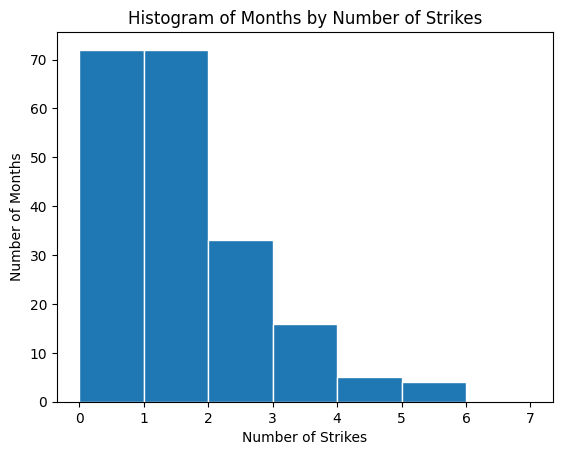

In [7]:
plt.hist(strikes5['num_strikes'], bins=[0,1,2,3,4,5,6,7], edgecolor='white')
plt.xlabel('Number of Strikes')
plt.ylabel('Number of Months')
plt.title('Histogram of Months by Number of Strikes')

# plt.hist(strikes5['strike_flag'])

#### Linear Regression

In [8]:
from sklearn.linear_model import LinearRegression

X = strikes5[['satisfied', 'Somewhat satisfied','Somewhat dissatisfied','Completely dissatisfied', 'real wage', 'cpi', 'R_Min_Wage']]
y= strikes5['num_strikes']

reg = LinearRegression().fit(X, y)
print(reg.coef_)
reg.score(X,y)

[ 0.40759429  0.48756615  0.39725266  0.4394458   0.01635543 11.60994468
 -0.01522674]


0.10736606781268865

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
scores = cross_val_score(reg, X, y, scoring='r2', cv=folds)
scores

array([ 0.15871019,  0.01281295,  0.02351521, -0.0175582 , -0.0143546 ])

<Axes: >

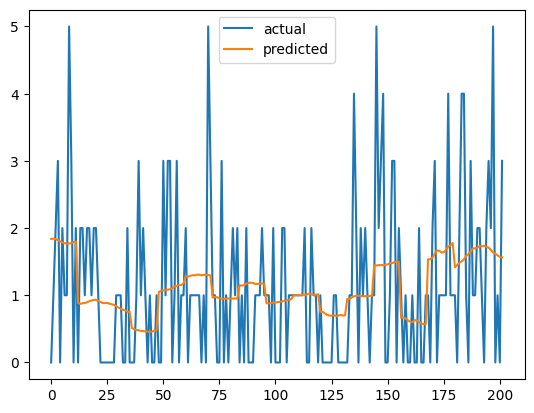

In [10]:
predicted = reg.predict(X)
df = pd.DataFrame({'actual': y, 'predicted' : predicted})[['actual', 'predicted']].reset_index()
del df['index']
df.plot.line()

#### Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

X = strikes5[['satisfied', 'Somewhat satisfied','Somewhat dissatisfied','Completely dissatisfied', 'cpi', 'R_Min_Wage']]
y = strikes5['strike_flag']

LR = LogisticRegression()
LR.fit(X,y)
print('Num Acc:', LR.score(X,y))



y = strikes5['above_avg']

LR2 = LogisticRegression(max_iter=10000)
LR2.fit(X,y)
print('Above Avg Acc:', LR2.score(X,y))


# LR.coef_

Num Acc: 0.6831683168316832
Above Avg Acc: 0.7128712871287128


C:\Users\tarun\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [12]:
from sklearn.inspection import permutation_importance

result = permutation_importance(LR, X, y, n_repeats=10, random_state=42, n_jobs=2)


importances = pd.Series(result.importances_mean, index=list(X.columns))

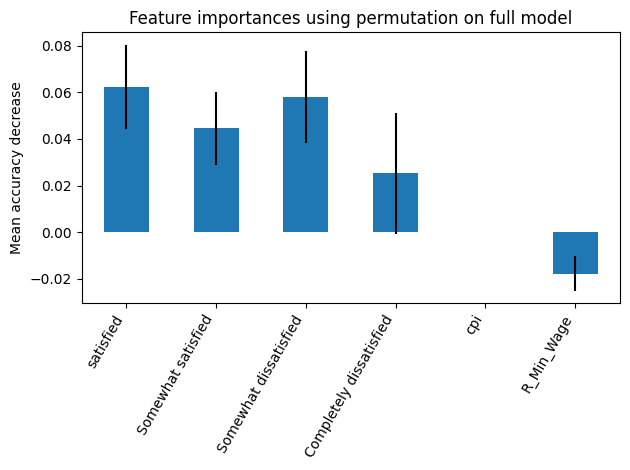

In [13]:
fig, ax = plt.subplots()
importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
plt.xticks(rotation=60, ha="right")
fig.tight_layout()
plt.show()


0.6097560975609756


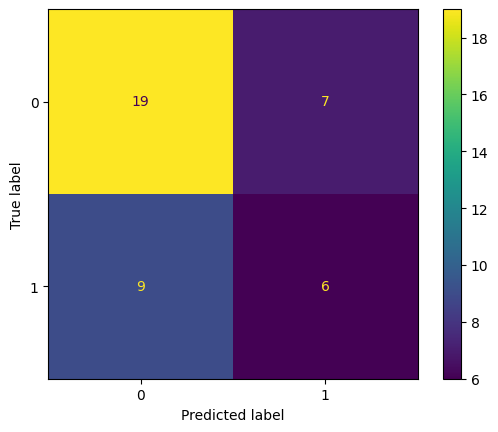

In [14]:
X = strikes5[['satisfied', 'Somewhat satisfied','Somewhat dissatisfied','Completely dissatisfied', 'real wage', 'cpi', 'R_Min_Wage']]
# X = strikes6[['satisfied', 'Somewhat satisfied','Somewhat dissatisfied','Completely dissatisfied', 'real wage', 'cpi', 'R_Min_Wage', '1MO Change RW', '3MO Change RW', '1YR Change RW']]

y = strikes5['strike_flag']
# y = strikes6['strike_flag']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

LR = LogisticRegression(max_iter = 1000)
LR.fit(X_train,y_train)

# LR.score(X_test,y_test), confusion_matrix(y_test, LR.predict(X_test)), confusion_matrix(y, LR.predict(X))

print(LR.score(X_test,y_test))


predictions = LR.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=LR.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=LR.classes_)
disp.plot()

plt.show()




### Scraps

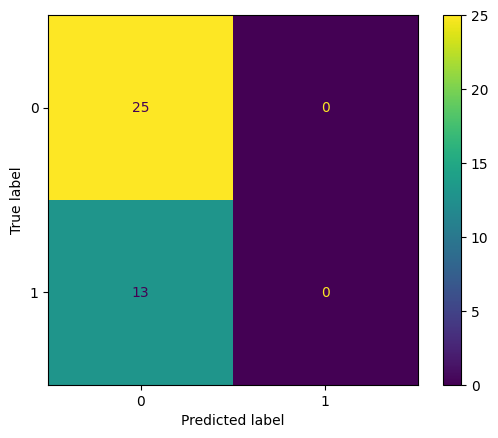

array([[25,  0],
       [13,  0]], dtype=int64)

In [19]:
from sklearn.svm import SVC

X = strikes6[['satisfied', 'Somewhat satisfied','Somewhat dissatisfied','Completely dissatisfied', 'real wage', 'cpi', 'R_Min_Wage', '1MO Change RW', '3MO Change RW', '1YR Change RW']]


y = strikes6['strike_flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

clf = SVC(random_state=0)
clf.fit(X_train, y_train)


clf.score(X_test, y_test)
predictions = clf.predict(X_test)

cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()

plt.show()
cm




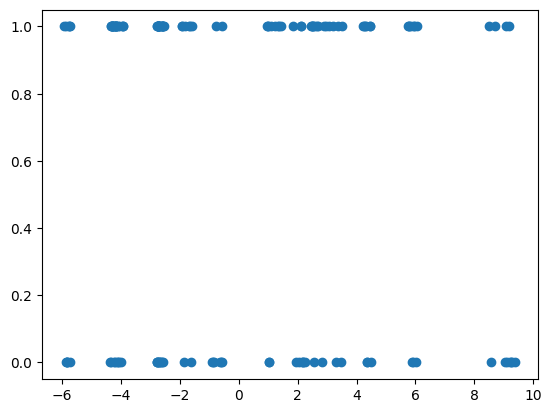

In [ ]:
from sklearn.decomposition import PCA
import numpy as np

X = strikes5[['satisfied', 'Somewhat satisfied','Somewhat dissatisfied','Completely dissatisfied', 'real wage', 'cpi', 'R_Min_Wage', '1MO Change RW', '3MO Change RW', '1YR Change RW']]


y = strikes5['strike_flag']


pca = PCA(random_state=88)
pca.fit(X_train)

explained_variance = np.cumsum(pca.explained_variance_ratio_)
# plt.vlines(x=80, ymax=1, ymin=0, colors="r", linestyles="--")
# plt.hlines(y=0.95, xmax=120, xmin=0, colors="g", linestyles="--")
# plt.plot(explained_variance)


pca_final = PCA(n_components=1)
df_train_pca = pca_final.fit_transform(X_train)

plt.scatter(df_train_pca, y_train)